# Loading the data using Datagenerators




The provided code snippet demonstrates how to load and preprocess image data using TensorFlow's Keras API. The steps are outlined below:

1. **Library Imports**: Import necessary libraries including TensorFlow, Keras, NumPy, and other utility functions for data handling and model building.

2. **Dataset Path Definition**: Define the path to the dataset. The dataset is assumed to be in a directory where each subdirectory represents a class containing images.

3. **Image Data Generator Initialization**: Initialize an `ImageDataGenerator` to load images. The images are rescaled by dividing each pixel value by 255.

    ```python
    datagen = ImageDataGenerator(rescale=1./255)
    ```

4. **Generator Configuration**: Configure the generator to load images from the dataset directory, setting parameters such as target image size, color mode, class mode, batch size, and shuffle.

    ```python
    generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(200, 200),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    ```

5. **Image and Label Collection**: Iterate over all batches provided by the generator and collect all images and labels into lists. Concatenate these lists into single NumPy arrays.

    ```python
    all_images = []
    all_labels = []

    for _ in range(generator.samples // generator.batch_size + 1):
        imgs, lbls = next(generator)
        all_images.append(imgs)
        all_labels.append(lbls)

    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    ```

6. **Dataset Splitting**: Split the dataset into training and testing sets using `train_test_split` from Scikit-learn.

    ```python
    X_train, X_test, Y_train, Y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
    ```

7. **Generator Creation for Training and Testing**: Create data generators for the training and testing datasets.

    ```python
    train_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)

    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow(X_test, Y_test, batch_size=32)
    ```

8. **Determine Steps per Epoch**: Calculate the number of steps per epoch and validation steps to ensure the generators produce enough batches during training and validation.

    ```python
    steps_per_epoch = len(train_generator)
    validation_steps = len(test_generator)
    ```

This code sets up the data pipeline required for training a neural network on image data by preparing data generators that can be fed directly into a Keras model.


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations, backend as K
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, History

# Define the path to your dataset
dataset_path = r"D:\jhansi_emg\internship_2024_may\time_domain"

# Create an instance of the ImageDataGenerator to load images
datagen = ImageDataGenerator(
    rescale=1./255  # Scale the images by dividing each pixel by 255
)

# Initialize the generator
generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(200, 200),
    color_mode='rgb',  # Load images in RGB
    class_mode='categorical',  # Labels are returned in categorical format
    batch_size=32,  # You can adjust the batch size according to your need
    shuffle=False  # Set to False to maintain consistent order across epochs (useful for this collection process)
)

# Prepare to collect all images and labels
all_images = []
all_labels = []

# Iterate over all batches and collect images and labels
for _ in range(generator.samples // generator.batch_size + 1):  # Ensure you capture all batches
    imgs, lbls = next(generator)
    all_images.append(imgs)
    all_labels.append(lbls)

# Concatenate all batches into single arrays
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Verify the shapes of the full datasets
print("All images shape:", all_images.shape)
print("All labels shape:", all_labels.shape)
X_train, X_test, Y_train, Y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
X_train.shape, Y_train.shape


# Create dataset and dataloader
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(X_test, Y_test, batch_size=32)

# Ensure that the generators produce enough batches
steps_per_epoch = len(train_generator)
validation_steps = len(test_generator)


Found 3307 images belonging to 3 classes.
All images shape: (3307, 200, 200, 3)
All labels shape: (3307, 3)


# Model Building & Testing

### Custom F1 Score Metric

**Purpose:** To provide a custom metric for evaluating the F1 score during model training and evaluation.

**Parameters:** None directly, but it operates on `y_true` and `y_pred`.

**Steps:**
1. Initialize true positives, false positives, and false negatives.
2. In `update_state()`, update these counts based on `y_true` and `y_pred`.
3. In `result()`, compute precision, recall, and the F1 score from these counts.

**Returns:** The computed F1 score.

---

### Squash Activation Function

**Purpose:** To apply the squash activation function, which is essential for Capsule Networks.

**Parameters:** 
- `x` (Tensor) - the input tensor.
- `axis` (int) - the axis along which to compute the squash function (default is -1).

**Steps:**
1. Compute the squared norm of the input tensor.
2. Compute the scale factor using the squared norm.
3. Return the scaled input tensor.

**Returns:** The transformed tensor after applying the squash function.

---

### Softmax Function

**Purpose:** To apply the softmax function along a specified axis.

**Parameters:**
- `x` (Tensor) - the input tensor.
- `axis` (int) - the axis along which to apply softmax (default is -1).

**Steps:**
1. Compute the exponentials of the input tensor.
2. Normalize by dividing by the sum of the exponentials along the specified axis.

**Returns:** The transformed tensor after applying softmax.

---

### Capsule Layer

**Purpose:** To define a Capsule layer for Capsule Networks.

**Parameters:**
- `num_capsule` (int) - the number of capsules.
- `dim_capsule` (int) - the dimension of each capsule.
- `routings` (int) - the number of routing iterations.
- `share_weights` (bool) - whether to share weights.
- `activation` (string) - the activation function to use (default is 'squash').

**Steps:**
1. Initialize the layer with the specified parameters.
2. Define the weight matrix.
3. In `call()`, compute the capsule output using dynamic routing and the squash function.

**Returns:** The output tensor of the Capsule layer.

---

### Attention Block

**Purpose:** To apply an attention mechanism to the input tensor, helping the model focus on important parts.

**Parameters:**
- `inputs` (Tensor) - the input tensor.
- `filters` (int) - the number of filters for the convolutional layers.

**Steps:**
1. Apply two convolutional layers with `relu` and `sigmoid` activations respectively.
2. Multiply the input tensor by the attention weights.

**Returns:** The transformed tensor after applying the attention mechanism.

---

### Residual Block

**Purpose:** To define a residual block, which helps in training deeper neural networks by mitigating the vanishing gradient problem.

**Parameters:**
- `inputs` (Tensor) - the input tensor.
- `filters` (int) - the number of filters for the convolutional layers.

**Steps:**
1. Apply two convolutional layers with batch normalization and ReLU activations.
2. Add the input tensor to the output tensor of the second convolutional layer.

**Returns:** The transformed tensor after applying the residual block.

---

### Model Architecture

**Purpose:** To define the complete model architecture, combining convolutional layers, residual blocks, attention blocks, capsule layers, and a final dense layer.

**Parameters:**
- `inputShape` (tuple) - the shape of the input data.

**Steps:**
1. Create an input layer.
2. Add an initial convolutional layer.
3. Add residual and attention blocks.
4. Add additional convolutional, pooling, and dropout layers.
5. Add a global average pooling layer.
6. Reshape the output and add a Capsule layer.
7. Add a dense layer and output layer.
8. Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy and F1 score metrics.

**Returns:** The compiled model.

---

### Training and Evaluation

**Purpose:** To train the model and evaluate its performance on the test data.

**Parameters:**
- `train_generator` - the training data generator.
- `test_generator` - the testing data generator.
- `epochs` (int) - the number of epochs to train (default is 80).

**Steps:**
1. Define callbacks for early stopping, reducing learning rate, and tracking history.
2. Train the model using `model.fit()`.
3. Plot training and validation accuracy and loss.
4. Evaluate the model on the test data.

**Returns:** Plots of training history and evaluation metrics (accuracy and F1 score).


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 200, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 100, 100, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

83/83 [==============================] - 357s 4s/step - loss: 0.5978 - accuracy: 0.7769 - f1_score: 0.7237 - val_loss: 1.9425 - val_accuracy: 0.3051 - val_f1_score: 0.3051
Epoch 2/80
83/83 [==============================] - 351s 4s/step - loss: 0.3135 - accuracy: 0.8779 - f1_score: 0.8780 - val_loss: 2.7517 - val_accuracy: 0.3051 - val_f1_score: 0.3051
Epoch 3/80
83/83 [==============================] - 358s 4s/step - loss: 0.2579 - accuracy: 0.8934 - f1_score: 0.8911 - val_loss: 1.8611 - val_accuracy: 0.3051 - val_f1_score: 0.3051
Epoch 4/80
83/83 [==============================] - 355s 4s/step - loss: 0.2502 - accuracy: 0.8964 - f1_score: 0.8973 - val_loss: 1.9141 - val_accuracy: 0.3051 - val_f1_score: 0.3051
Epoch 5/80
83/83 [==============================] - 351s 4s/step - loss: 0.2227 - accuracy: 0.9146 - f1_score: 0.9140 - val_loss: 2.7292 - val_accuracy: 0.3051 - val_f1_score: 0.3051
Epoch 6/80
83/83 [==============================] - 345s 4s/step - loss: 0.2095 - accuracy: 0.91

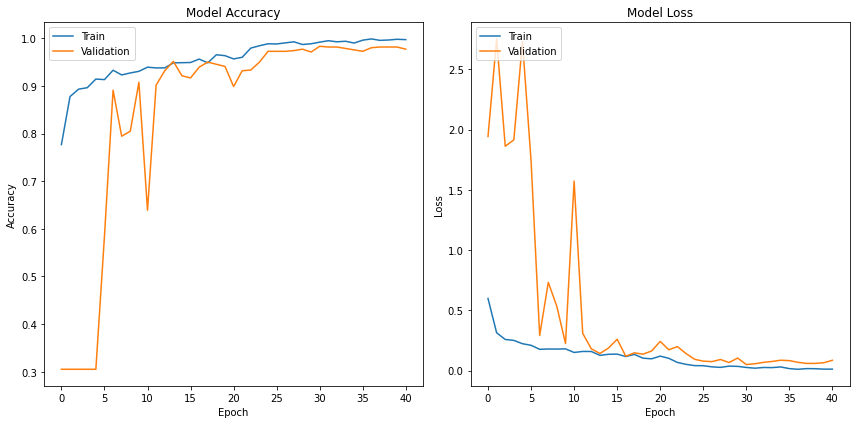

21/21 - 9s - loss: 0.0499 - accuracy: 0.9834 - f1_score: 0.9841
Test Accuracy: 0.9833837151527405
Test F1 Score: 0.9841268658638


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# Custom F1 Score Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

# Squash Activation Function
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# Softmax Function
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# Capsule Layer
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = layers.Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        b = K.zeros_like(u_hat_vecs[:,:,:,0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)
        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

# Attention Mechanism
def attention_block(inputs, filters):
    attention = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(inputs)
    attention = layers.Conv2D(filters, (1, 1), activation='sigmoid', padding='same')(attention)
    return layers.multiply([inputs, attention])

# Residual Block
def residual_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the model architecture
def get_model(inputShape):
    input_image = Input(shape=inputShape)

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Blocks with Attention
    for _ in range(2):
        x = residual_block(x, 32)
        x = attention_block(x, 32)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 64)
        x = attention_block(x, 64)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 128)
        x = attention_block(x, 128)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 256)
        x = attention_block(x, 256)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capsule Layer
    x = layers.Reshape((-1, 256))(x)
    capsule = Capsule(num_capsule=10, dim_capsule=16, routings=3, share_weights=True)(x)
    capsule = layers.Flatten()(capsule)
    capsule = layers.Dense(128, activation='relu')(capsule)
    capsule = layers.Dropout(0.5)(capsule)

    # Output Layer
    output = layers.Dense(3, activation='softmax')(capsule)

    # Create and compile the model
    model = models.Model(inputs=input_image, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', F1Score()])
    model.summary()

    return model

# Instantiate the model
model = get_model((200, 200, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# History callback
history = History()

# Train the model
epochs = 80
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)


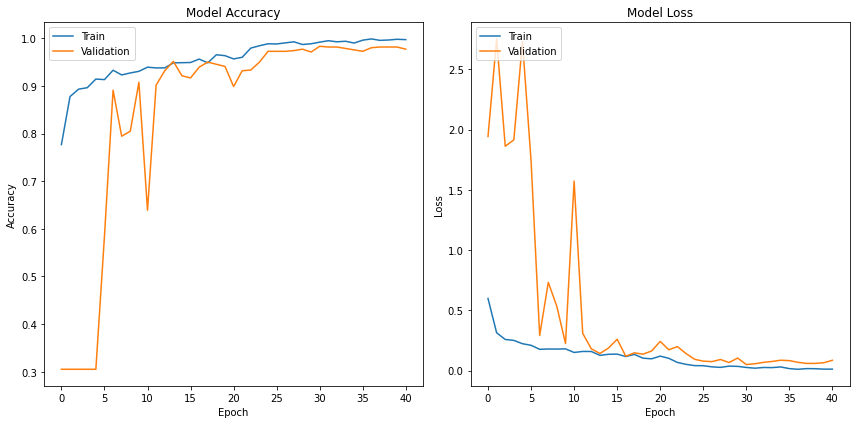

In [4]:

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


In [5]:
# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)


21/21 - 9s - loss: 0.0499 - accuracy: 0.9834 - f1_score: 0.9841
Test Accuracy: 0.9833837151527405
Test F1 Score: 0.9841268658638


# using RectifiedAdam

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
_________________________________________________________________________________

83/83 [==============================] - 356s 4s/step - loss: 0.9488 - accuracy: 0.5758 - f1_score: 0.3215 - val_loss: 1.2378 - val_accuracy: 0.3051 - val_f1_score: 0.3051
Epoch 2/80
83/83 [==============================] - 346s 4s/step - loss: 0.4947 - accuracy: 0.8378 - f1_score: 0.8308 - val_loss: 1.4848 - val_accuracy: 0.3051 - val_f1_score: 0.3051
Epoch 3/80
83/83 [==============================] - 346s 4s/step - loss: 0.3535 - accuracy: 0.8684 - f1_score: 0.8680 - val_loss: 2.1717 - val_accuracy: 0.3051 - val_f1_score: 0.3051
Epoch 4/80
83/83 [==============================] - 348s 4s/step - loss: 0.2905 - accuracy: 0.8839 - f1_score: 0.8826 - val_loss: 1.3216 - val_accuracy: 0.3051 - val_f1_score: 0.3051
Epoch 5/80
83/83 [==============================] - 344s 4s/step - loss: 0.2713 - accuracy: 0.8960 - f1_score: 0.8919 - val_loss: 1.5344 - val_accuracy: 0.3051 - val_f1_score: 0.3051
Epoch 6/80
83/83 [==============================] - 340s 4s/step - loss: 0.2293 - accuracy: 0.90

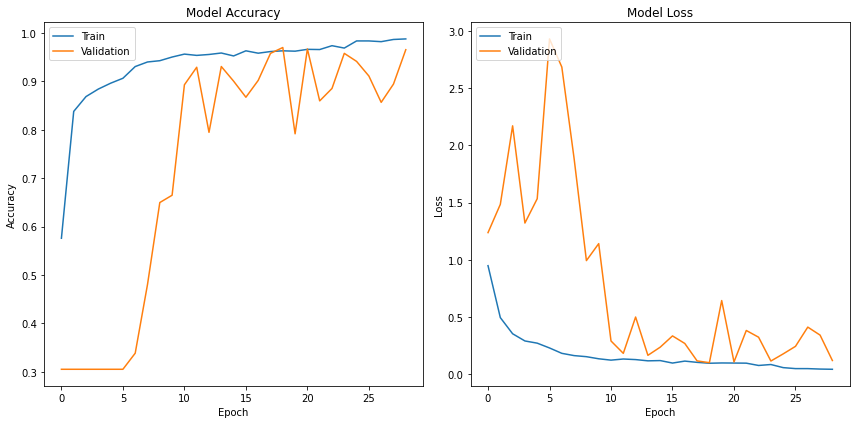

21/21 - 15s - loss: 0.1006 - accuracy: 0.9698 - f1_score: 0.9690
Test Accuracy: 0.9697884917259216
Test F1 Score: 0.9689628481864929


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations, backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow_addons.optimizers import RectifiedAdam
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# Custom F1 Score Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1

# Squash Activation Function
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# Softmax Function
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# Capsule Layer
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = layers.Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        b = K.zeros_like(u_hat_vecs[:,:,:,0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)
        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

# Attention Mechanism
def attention_block(inputs, filters):
    attention = layers.Conv2D(filters, (1, 1), activation='relu', padding='same')(inputs)
    attention = layers.Conv2D(filters, (1, 1), activation='sigmoid', padding='same')(attention)
    return layers.multiply([inputs, attention])

# Residual Block
def residual_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the model architecture
def get_model(inputShape):
    input_image = Input(shape=inputShape)

    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Residual Blocks with Attention
    for _ in range(2):
        x = residual_block(x, 32)
        x = attention_block(x, 32)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 64)
        x = attention_block(x, 64)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 128)
        x = attention_block(x, 128)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    for _ in range(2):
        x = residual_block(x, 256)
        x = attention_block(x, 256)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capsule Layer
    x = layers.Reshape((-1, 256))(x)
    capsule = Capsule(num_capsule=10, dim_capsule=16, routings=3, share_weights=True)(x)
    capsule = layers.Flatten()(capsule)
    capsule = layers.Dense(128, activation='relu')(capsule)
    capsule = layers.Dropout(0.5)(capsule)

    # Output Layer
    output = layers.Dense(3, activation='softmax')(capsule)

    # Create and compile the model
    model = models.Model(inputs=input_image, outputs=output)

    # Use RectifiedAdam optimizer for teacher training
    radam = RectifiedAdam(learning_rate=1e-3)

    model.compile(loss='categorical_crossentropy', optimizer=radam, metrics=['accuracy', F1Score()])
    model.summary()

    return model

# Instantiate the model
model = get_model((200, 200, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# History callback
history = History()

# Train the model
epochs = 80
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)

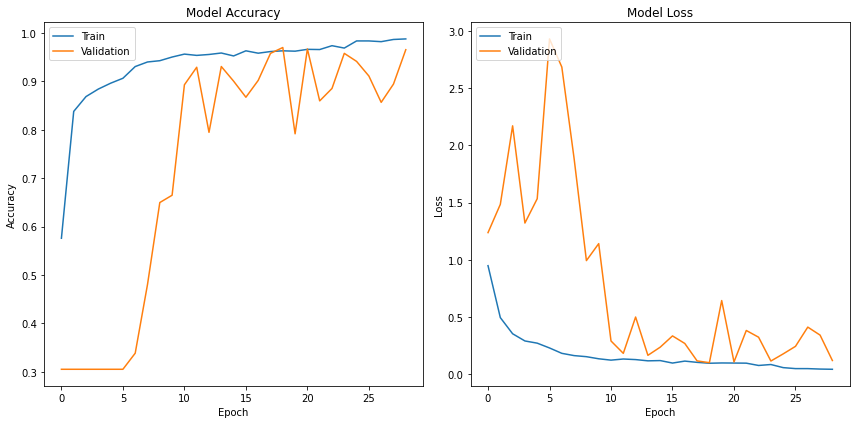

21/21 - 15s - loss: 0.1006 - accuracy: 0.9698 - f1_score: 0.9690
Test Accuracy: 0.9697884917259216
Test F1 Score: 0.9689628481864929


In [7]:

# Plot training & validation accuracy and loss values in a single graph
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


# Evaluate the model
test_loss, test_acc, test_f1_score = model.evaluate(test_generator, verbose=2)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1_score)
